In [1]:
from func_utils.plot_utils import show_image
import matplotlib.pyplot as plt 
from glob import glob
import pandas as pd 
import numpy as np 
import json
import os 

import torch 
from func_utils.pydataloader import SynthDogDataset
from func_utils.trainer_utils import *
from encoder_decoder_model import (
    init_dit_mbert_models_fixed, init_dit_dbart_models, 
    print_model_layer_sizes, load_pretrained_enc_dec_model, load_pretrained_iprocessor_tokenizer
    )

import wandb
import gc

torch.cuda.empty_cache()
gc.collect()
wandb.login()

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: beasted90 (beasted90-comudel) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
from encoder_decoder_model import resize_position_embeddings

In [3]:
def get_synth_images_json_path(data_root= os.path.join('synthdog','outputs'), split='train'):
    ipath = os.path.join(data_root, '*', split, '*.jpg')
    json_path = os.path.join(data_root, '*', split, 'metadata.jsonl')

    return glob(ipath), glob(json_path)


torch.cuda.empty_cache()

root_path = os.path.join('synthdog', 'outputs')
train_ipath, train_json_metadata = get_synth_images_json_path(data_root=root_path, split='train')
val_ipath, val_json_metadata = get_synth_images_json_path(data_root=root_path, split='validation')
# test_ipath, test_json_metadata = get_synth_images_json_path(data_root=root_path, split='test')
# processor, text_tokenizer = init_dit_dbart_models(load_model=False)
# model.gradient_checkpointing_enable()

peak_mem = torch.cuda.max_memory_allocated()
print(f"The model as is is holding: {peak_mem / 1024**3:.2f} of GPU RAM")

The model as is is holding: 0.00 of GPU RAM


In [4]:
text = 'ÁGUA É ESSENCIAL PARA A COMPREENSÃO E AÇÃO; CÂNCER, ÓRGÃOS, EMOÇÃO, TÊM INFLUÊNCIA, E ÍNDICES MOSTRAM EVOLUÇÃO.'
text2 = "água é essencial para a compreensão e ação; câncer, órgãos, emoção, têm influência, e índices mostram evolução."

# text_tokenizer.decode(text_tokenizer(text).input_ids)

In [5]:
run_name = "dtesting"
# wandb.init(project="ocr model", name=run_name)

In [6]:
# image_processor, text_tokenizer = init_dit_dbart_models(load_model=False)
# decoder = "naver-clova-ix/donut-base"
# ckpt_path = 'saved_models\mydit_dbart'
# ovmodel = load_pretrained_enc_dec_model(ckpt_path, base_encoder_model=None, 
#                                         base_decoder_model=decoder, 
#                                         lora_applied=False, 
#                                         new_tokens=['Ã', 'Ê', 'Â']
#                                     )


ckpt = 'saved_models\mydit768_dbart'
image_processor, text_tokenizer = load_pretrained_iprocessor_tokenizer(ckpt)
ovmodel = load_pretrained_enc_dec_model(ckpt, None, None, lora_applied=False)

loading pre-trained tokenizer
Loaded the pre-trained model successfully...


In [7]:
print_model_layer_sizes(ovmodel)

encoder.embeddings.cls_token: 768 parameters | torch.Size([1, 1, 768])
encoder.embeddings.position_embeddings: 1770240 parameters | torch.Size([1, 2305, 768])
encoder.embeddings.patch_embeddings.projection.weight: 589824 parameters | torch.Size([768, 3, 16, 16])
encoder.embeddings.patch_embeddings.projection.bias: 768 parameters | torch.Size([768])
encoder.encoder.layer.0.lambda_1: 768 parameters | torch.Size([768])
encoder.encoder.layer.0.lambda_2: 768 parameters | torch.Size([768])
encoder.encoder.layer.0.attention.attention.query.weight: 589824 parameters | torch.Size([768, 768])
encoder.encoder.layer.0.attention.attention.query.bias: 768 parameters | torch.Size([768])
encoder.encoder.layer.0.attention.attention.key.weight: 589824 parameters | torch.Size([768, 768])
encoder.encoder.layer.0.attention.attention.value.weight: 589824 parameters | torch.Size([768, 768])
encoder.encoder.layer.0.attention.attention.value.bias: 768 parameters | torch.Size([768])
encoder.encoder.layer.0.atte

In [8]:
max_token_size = 1056
sample_size = 32
train_synthdataset = SynthDogDataset(train_ipath, train_json_metadata, image_feature_extractor=image_processor, 
                                     text_tokenizer=text_tokenizer, max_token_size=max_token_size, sample_size=sample_size)
val_synthdataset = SynthDogDataset(val_ipath, val_json_metadata, image_feature_extractor=image_processor, 
                                   text_tokenizer=text_tokenizer, max_token_size=max_token_size, sample_size=4)

['synthdog\\outputs\\SynthDoG-en\\train\\image_0.jpg', 'synthdog\\outputs\\SynthDoG-en\\train\\image_1.jpg']
Sampled lang counter: {'SynthDoG-pt': 16, 'SynthDoG-en': 16}
Length of _.images: 32 | Length of _.json_metadata: 91
['synthdog\\outputs\\SynthDoG-en\\validation\\image_43.jpg']
Sampled lang counter: {'SynthDoG-en': 1}
Length of _.images: 1 | Length of _.json_metadata: 1


In [9]:
# r=32
# alpha=r*2
# dropout=0.3
# target_modules = [
#         "q_proj", "k_proj", "v_proj", "out_proj",
# ]
# modules_to_save = None

num_epochs = 20
training_args = Seq2SeqTrainingArguments(
        output_dir=f"./{run_name}",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=1,
        learning_rate=5e-4,  
        lr_scheduler_type="cosine",
        num_train_epochs=num_epochs,
        warmup_ratio=0.1,  
        logging_steps=10,
        logging_strategy="steps",
        save_total_limit=3,
        fp16=True,
        max_grad_norm=10,  
        weight_decay=0.01,
        
        dataloader_pin_memory=False,
        predict_with_generate=True,
        generation_max_length=max_token_size,
        generation_num_beams=1,
        report_to=["wandb"],
        run_name=run_name,
        save_safetensors=False,

        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model="eval_loss",
        load_best_model_at_end=True,  
        greater_is_better=False,
        )

In [10]:
ovmodel.config.max_length = max_token_size
ovmodel.config.decoder.max_length = max_token_size
# dropout = 0.2
ovmodel.config.min_length = 1
ovmodel.config.decoder.min_length = 1
ovmodel.config.no_repeat_ngram_size = 0
ovmodel.config.repetition_penalty = 1.2
ovmodel.config.length_penalty = 1.0 
# ovmodel.config.early_stopping = True
ovmodel.config.num_beams = 1
ovmodel.config.use_cache = False  
ovmodel.config.is_encoder_decoder = True
ovmodel.config.do_sample = False  
ovmodel.config.tie_word_embeddings = True
print_trainable_prams(ovmodel)

✅ Trainable: encoder.embeddings.cls_token
✅ Trainable: encoder.embeddings.position_embeddings
✅ Trainable: encoder.embeddings.patch_embeddings.projection.weight
✅ Trainable: encoder.embeddings.patch_embeddings.projection.bias
✅ Trainable: encoder.encoder.layer.0.lambda_1
✅ Trainable: encoder.encoder.layer.0.lambda_2
✅ Trainable: encoder.encoder.layer.0.attention.attention.query.weight
✅ Trainable: encoder.encoder.layer.0.attention.attention.query.bias
✅ Trainable: encoder.encoder.layer.0.attention.attention.key.weight
✅ Trainable: encoder.encoder.layer.0.attention.attention.value.weight
✅ Trainable: encoder.encoder.layer.0.attention.attention.value.bias
✅ Trainable: encoder.encoder.layer.0.attention.output.dense.weight
✅ Trainable: encoder.encoder.layer.0.attention.output.dense.bias
✅ Trainable: encoder.encoder.layer.0.intermediate.dense.weight
✅ Trainable: encoder.encoder.layer.0.intermediate.dense.bias
✅ Trainable: encoder.encoder.layer.0.output.dense.weight
✅ Trainable: encoder.enco

In [11]:
ovmodel.config.decoder.max_position_embeddings

1536

In [12]:
text_tokenizer.bos_token_id

0

In [13]:
ovmodel.config.decoder.vocab_size, len(text_tokenizer)

(57528, 57528)

In [14]:
ovmodel.config.max_length

1056

In [15]:
print(ovmodel.decoder.get_input_embeddings().weight.shape)

torch.Size([57528, 1024])


In [16]:
ovmodel.decoder.lm_head

Linear(in_features=1024, out_features=57528, bias=False)

In [17]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5, 
)
trainer = setup_dit_bart_training(
        train_synthdataset, val_synthdataset, training_args=training_args, model=ovmodel, text_tokenizer=text_tokenizer,
        run_name = run_name, 
        callbacks=[early_stopping_callback],
        max_length=max_token_size
    )

c:\Users\jaabi\Documents\comudel\ocr\func_utils\trainer_utils.py:246: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [18]:
history = trainer.train()

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss,Bleu,Pred Intersect Labels
1,No log,7.169275,0.000000,0.150000
2,8.626900,7.931543,0.000000,0.400000
3,6.897600,7.885177,0.000000,0.166667
4,6.361500,8.533754,0.000000,1.000000
5,6.228400,8.246597,0.000000,0.250000
6,6.228400,8.719202,0.000000,0.200000


Evaluating ...
GT
ousands wir e may h ave a diff erent colo r.The Russian abacus was in use in s hops and

Pred
e the a des  andme, toees in sded oceve of emaas as tpes be nen m com dem r he


c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\transformers\modeling_utils.py:4034: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1056, 'min_length': 1, 'repetition_penalty': 1.2}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Evaluating ...
GT
ousands wir e may h ave a diff erent colo r.The Russian abacus was in use in s hops and

Pred
o e a de,ç emsaões.
Evaluating ...
GT
ousands wir e may h ave a diff erent colo r.The Russian abacus was in use in s hops and

Pred
,os de a umis ee des
Evaluating ...
GT
ousands wir e may h ave a diff erent colo r.The Russian abacus was in use in s hops and

Pred
a
Evaluating ...
GT
ousands wir e may h ave a diff erent colo r.The Russian abacus was in use in s hops and

Pred
o a  deas eário
Evaluating ...
GT
ousands wir e may h ave a diff erent colo r.The Russian abacus was in use in s hops and

Pred
, a time thes. he


In [25]:
import numpy as np 

ovmodel.eval()
vind = np.random.randint(0, len(train_synthdataset))
sample = train_synthdataset[vind]  
inputs = sample["pixel_values"].unsqueeze(0).to(ovmodel.device)
image = sample['image']
text = sample['text']
output_ids = ovmodel.generate(inputs, max_length=100)
prediction = text_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Prediction:", prediction)
print("Ground Truth:", sample["text"])

Prediction: de a ee theses meveded,ceseo omemaspes s
Ground Truth: nse of time passin g, time lost, and the relati onship of


In [ ]:
output_ids = ovmodel.generate(inputs, max_length=100, num_beams=1)
prediction = text_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Prediction:", prediction)
print("Ground Truth:", sample["text"])

Prediction: s a of deiing,  theify are. Africa
Ground Truth: found in Ysterfontein on the western coast of South Africa are associated with the Middle Stone Age


In [ ]:
from transformers import VisionEncoderDecoderModel, AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("naver-clova-ix/donut-base")
tmodel = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
tmodel.eval()
vind = np.random.randint(0, len(train_synthdataset))
sample = train_synthdataset[vind]  
inputs = processor(sample['image'],return_tensors="pt").pixel_values.to(tmodel.device)
image = sample['image']
text = sample['text']
text

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


'study of the Indic texts until the summer of'

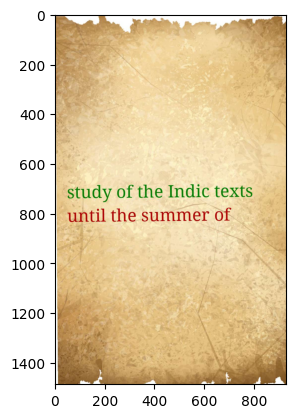

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(image)

In [ ]:
output_ids = tmodel.generate(inputs, max_length=100, num_beams=6)
prediction = text_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Prediction:", prediction)
print("Ground Truth:", sample["text"])

Prediction: 
Ground Truth: study of the Indic texts until the summer of


In [ ]:
inputs = sample["pixel_values"].unsqueeze(0).to(ovmodel.device)
output_ids = ovmodel.generate(inputs, max_length=100, num_beams=6)
prediction = text_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Prediction:", prediction)
print("Ground Truth:", sample["text"])

Prediction: 
Ground Truth: study of the Indic texts until the summer of
